Iteration: 0, train loss: 21.351015090942383
2025-05-05 14:21:17, Iteration: 0, Test Loss: 10.59046745300293


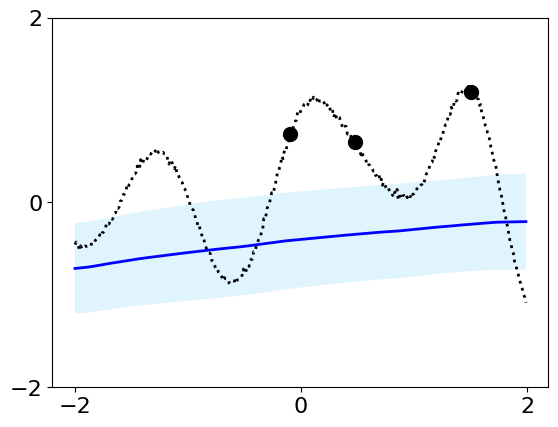

Iteration: 1000, train loss: 0.7655149698257446
Iteration: 2000, train loss: 0.8631172180175781
Iteration: 3000, train loss: 0.46430954337120056
Iteration: 4000, train loss: -0.15511558949947357
Iteration: 5000, train loss: 0.318642258644104
Iteration: 6000, train loss: -0.08325771987438202
Iteration: 7000, train loss: 0.8935996294021606
Iteration: 8000, train loss: 0.3948413133621216
Iteration: 9000, train loss: -0.1569226235151291
Iteration: 10000, train loss: -0.28692445158958435
Iteration: 11000, train loss: 0.17445650696754456
Iteration: 12000, train loss: -0.388557106256485
Iteration: 13000, train loss: 0.009003011509776115
Iteration: 14000, train loss: -0.45080599188804626
Iteration: 15000, train loss: -0.4471433162689209
Iteration: 16000, train loss: -0.14582590758800507
Iteration: 17000, train loss: -0.353264182806015
Iteration: 18000, train loss: -0.3908863067626953
Iteration: 19000, train loss: -0.5131801962852478
Iteration: 20000, train loss: -0.8498854637145996
2025-05-05 

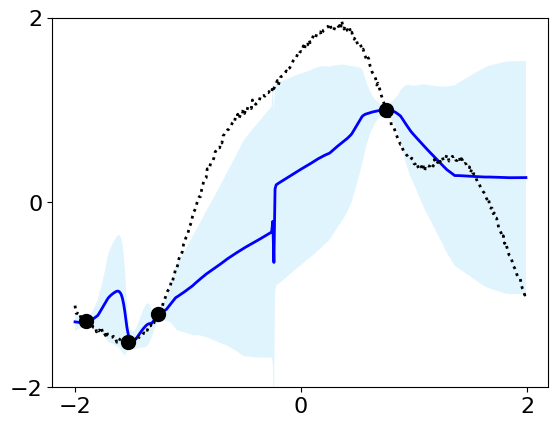

KeyboardInterrupt: 

In [3]:
import os
# os.chdir("../../src")
# os.chdir("drive/MyDrive/fyp/src")

from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP

import datetime
import torch
from torch.distributions.kl import kl_divergence

from modules import NLLLoss, ELBOLoss

from data import GPCurvesReader
from utils import plot_functions

TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
MAX_CONTEXT_POINTS = 10
torch.manual_seed(0)

# Train dataset
dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

criterion = ELBOLoss()

# Model
model = AttnLNP(1, 1, gp=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for it in range(TRAINING_ITERATIONS+1):
    # Sample a batch from the training dataset
    data_train = dataset_train.generate_curves()
    context_x, context_y, target_x, target_y, num_targets, _ = data_train

    optimizer.zero_grad()
    dist, z, q_zc, q_zct = model(context_x, context_y, target_x, target_y)
    # log_prob = None if target_y is None else dist.log_prob(target_y)
    # # kl = kl_divergence(q_zct, q_zc)
    # # kl = kl.sum(dim=-1, keepdim=True)
    # # loss = torch.mean(log_prob.squeeze(0) - kl / float(num_targets))
    # loss = -log_prob.mean()
    loss = criterion(dist, q_zct, q_zc, target_y)
    # loss = criterion(dist, target_y)
    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        print("Iteration: {}, train loss: {}".format(it, loss))

    # Plot and print the loss every PLOT_AFTER iterations
    if it % PLOT_AFTER == 0:
        data_test = dataset_test.generate_curves()
        context_x, context_y, target_x, target_y, num_targets, _ = data_test
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x, context_y, target_x, target_y
        )
        pred_y = test_dist.mean.mean(0)
        std = test_dist.stddev.mean(0)
        # test_log_prob = None if target_y is None else test_dist.log_prob(target_y)
        # # test_kl = kl_divergence(test_q_zct, test_q_zc)
        # # test_kl = test_kl.sum(dim=-1, keepdim=True)
        # # test_loss = -torch.mean(test_log_prob.squeeze(0) - test_kl / float(num_targets))
        # test_loss = -test_log_prob.mean()
        test_loss = criterion(test_dist, test_q_zct, test_q_zc, target_y)
        # test_loss = criterion(test_dist, target_y)

        print(
            "{}, Iteration: {}, Test Loss: {}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss
            )
        )

        plot_functions(
            target_x.detach().numpy(),
            target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            std.detach().numpy(),
        )


In [5]:
torch.save(model.state_dict(), "/content/models/" + model.__class__.__name__ + ".pt")